In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_baseline = pd.read_csv(r'../data/FBaseline.txt', sep='|')
df_baseline.drop(columns=['RecID','SiteID','EligChecklist','DomHand','AnnualInc',
                          'AnnualIncDNA','AnnualIncUnk', 'InsDelPump', 'ConfStudyBGMCellPhMatch','EduLevelUnk',
                          'ConfStudyBGMSyncPump','ConfPtRemNoAdjTime','SensorPlaced','SensorLoc','UrinePregTestResult','WeightNotDone', 'HeightNotDone'], inplace = True)
df_baseline['EduLevel'] = df_baseline['EduLevel'].replace(['1st, 2nd, 3rd, or 4th grade','5th or 6th grade','7th or 8th Grade','9th Grade','10th Grade', '11th Grade','12th Grade - no diploma', 'High school graduate/diploma/GED'], '1')
df_baseline['EduLevel'] = df_baseline['EduLevel'].replace(['Professional Degree','Some college but no degree',"Bachelor's Degree","Master's Degree","Associate Degree","Doctorate Degree" ], '2')



df_cgm = pd.read_csv(r'../data/FDataCGM.txt', sep='|')

df_cgm['CGM'] = df_cgm['Glucose']/18.018
df_cgm.drop(columns=['RecID','SiteID','FileUniqueRecID','Glucose'], inplace = True)
df_cgm = df_cgm.sort_values(by=['PtID', 'DeviceDaysFromEnroll', 'DeviceTm'])


df_roster = pd.read_csv(r'../data/FPtRoster.txt', sep='|')
df_roster2 = pd.read_csv(r'../data_2/FPtRosterNew.txt', sep='|')
df_roster2['AgeGroup'] = df_roster2['ageAtEnroll'].apply(lambda x: 2 if x > 17 else 1)


df_roster.drop(columns=['RecID','SiteID'], inplace = True)
df_roster['RaceProtF'] = df_roster['RaceProtF'].replace('Non-Hispanic Black', 'black')
df_roster['RaceProtF'] = df_roster['RaceProtF'].replace('Non-Hispanic White', 'white')
df_roster.rename(columns={'RaceProtF':"Race"}, inplace=True)
df_roster= df_roster[df_roster['FPtStatus'] != 'Dropped']
df_roster.drop("FPtStatus", axis=1, inplace=True)
df_roster2= df_roster2[df_roster2['FPtStatus'] != 'Dropped']

# removes patients dropped from study
df_cgm = df_cgm[df_cgm['PtID'].isin(df_roster['PtID'])] 
df_cgm_unique = df_cgm['PtID'].unique()

df_baseline = df_baseline[df_baseline['PtID'].isin(df_roster['PtID'])] 


# Calculate for each group

In [38]:
# Race
# df_roster= df_roster[df_roster['Race'] != 'black']
# df_cgm = df_cgm[df_cgm['PtID'].isin(df_roster['PtID'])] 
# df_cgm_unique = df_cgm['PtID'].unique()

# df_baseline = df_baseline[df_baseline['PtID'].isin(df_roster['PtID'])] 
# df_roster2 = df_roster2[df_roster2['PtID'].isin(df_baseline['PtID'])] 

# Gender
# df_baseline= df_baseline[df_baseline['Gender'] != 'F']
# df_cgm = df_cgm[df_cgm['PtID'].isin(df_baseline['PtID'])] 
# df_cgm_unique = df_cgm['PtID'].unique()
# df_roster = df_roster[df_roster['PtID'].isin(df_baseline['PtID'])] 
# df_roster2 = df_roster2[df_roster2['PtID'].isin(df_baseline['PtID'])] 

# EduLevel 
# df_baseline = df_baseline.dropna(subset=['EduLevel'])
# df_baseline= df_baseline[df_baseline['EduLevel'] != '2']

# df_cgm = df_cgm[df_cgm['PtID'].isin(df_baseline['PtID'])] 
# df_cgm_unique = df_cgm['PtID'].unique()
# df_roster = df_roster[df_roster['PtID'].isin(df_baseline['PtID'])] 
# df_roster2 = df_roster2[df_roster2['PtID'].isin(df_baseline['PtID'])] 

# Age
df_roster2 = df_roster2[df_roster2['AgeGroup'] != 1]

df_cgm = df_cgm[df_cgm['PtID'].isin(df_roster2['PtID'])] 
df_cgm_unique = df_cgm['PtID'].unique()
df_baseline = df_baseline[df_baseline['PtID'].isin(df_roster2['PtID'])] 
df_roster = df_roster[df_roster['PtID'].isin(df_baseline['PtID'])] 


# Looking at blood glucose measurements

In [39]:
print(df_cgm.CGM.describe())
print(df_cgm.agg({'CGM':  ["min", "max", "median", "skew"]}))

count    748084.000000
mean          9.154486
std           4.534450
min           2.220002
25%           5.716506
50%           8.436008
75%          11.877012
max          27.750028
Name: CGM, dtype: float64
              CGM
min      2.220002
max     27.750028
median   8.436008
skew     0.855473


# Convertions

### Convert lbs and inches to metric system and calculate BMI

In [40]:
def convert_units(row):
    # Converting Weight to kg
    if row['WeightUnits'] == 'lbs':
        row['Weight'] = row['Weight'] * 0.453592
        row['WeightUnits'] = 'kg'
    
    # Converting Height to cm
    if row['HeightUnits'] == 'in':
        row['Height'] = row['Height'] * 2.54
        row['HeightUnits'] = 'cm'
    
    return row

def calculate_bmi(weight, height_cm):
    """
    Calculate the Body Mass Index (BMI) using weight in kilograms and height in centimeters.
    
    Parameters:
    - weight: Weight in kilograms.
    - height_cm: Height in centimeters.
    
    Returns:
    - BMI as a float.
    """
    if height_cm <= 0 or weight <= 0:
        raise ValueError("Weight and height must be greater than zero.")
    
    height_m = height_cm / 100  # Convert height from cm to meters
    bmi = weight / (height_m ** 2)
    return bmi

# Applying the conversion to each row
df_baseline = df_baseline.apply(convert_units, axis=1)
df_baseline['BMI'] = df_baseline.apply(lambda row: calculate_bmi(row['Weight'], row['Height']), axis=1)


##### Height of PtID 156 being 162 inches or 411.48 cm
Changing it to 162 cm

In [41]:

count_411 = (df_baseline.isin([411.48])).sum().sum()                    # Checking if there are any other values being 411.48
df_baseline.replace(411.48, 162, inplace=True)
print(count_411)
# df_baseline.head(n=10)

1


## convert HbA1c from % to mmol/mol

In [42]:

def convert_hba1c_row(row):
    """
    Convert HbA1c value from percentage (%) to mmol/mol for a DataFrame row.
    
    Parameters:
    - row: A row from a pandas DataFrame.
    
    Assumes:
    - The HbA1c percentage value is stored in a column named 'HbA1c_percent' in the row.
    
    Returns:
    - The row with a new HbA1c value in mmol/mol added to it.
    """
    # Assuming the column is named 'HbA1c_percent'
    hba1c_percent = row['HbA1c']
    row['HbA1c'] = (hba1c_percent - 2.15) * 10.929
    return row

df_baseline = df_baseline.apply(convert_hba1c_row, axis=1)


# Checking for number of weeks

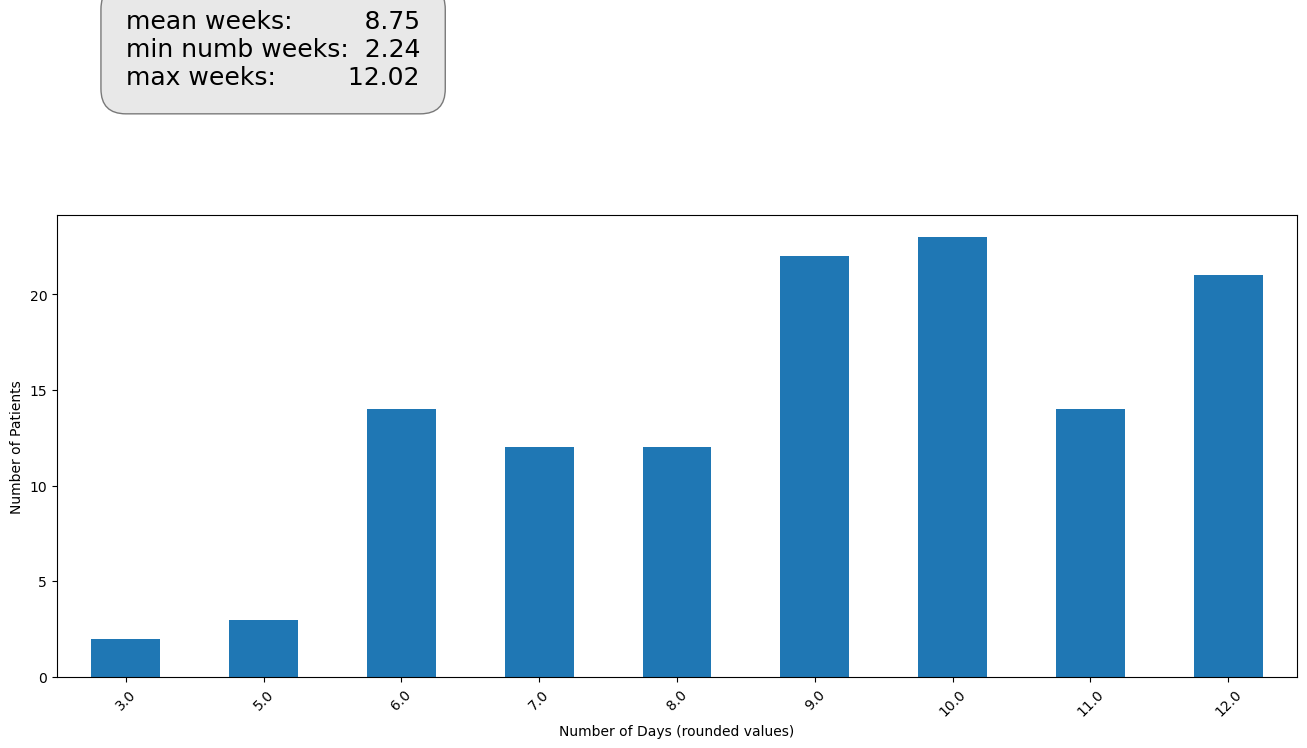

In [43]:
df_results = pd.DataFrame()

df_results['Datapoints'] = df_cgm['PtID'].value_counts()

# calculate number of days per patient 
df_results['Days'] = df_results['Datapoints']/24/4
df_results['Weeks'] = df_results['Datapoints']/24/4/7
df_results=df_results.reset_index()


numb_weeks_total = df_results.Weeks.sum()
numb_weeks_mean = df_results.Weeks.mean()
numb_weeks_min = df_results.Weeks.min()
numb_weeks_max = df_results.Weeks.max()

df_results = pd.merge(df_results, df_roster, on='PtID')

df_results_gr1 = df_results [df_results ['Race'] == 'white']
df_results_gr2 = df_results [df_results ['Race'] == 'black']

numb_weeks_gr1_total = df_results_gr1.Weeks.sum()
numb_weeks_gr1_mean = df_results_gr1.Weeks.mean()
numb_weeks_gr1_min = df_results_gr1.Weeks.min()
numb_weeks_gr1_max = df_results_gr1.Weeks.max()

numb_weeks_gr2_total = df_results_gr2.Weeks.sum()
numb_weeks_gr2_mean = df_results_gr2.Weeks.mean()
numb_weeks_gr2_min = df_results_gr2.Weeks.min()
numb_weeks_gr2_max = df_results_gr2.Weeks.max()

# Plotting
df_results['Weeks_round']=round(df_results.Weeks)
value_counts = df_results['Weeks_round'].value_counts().sort_index()

plt.figure(figsize=(16, 6))  # You can adjust the dimensions as needed
value_counts.plot(kind='bar')
plt.xticks(rotation=45)  # Rotates labels to 45 degrees
plt.xlabel('Number of Days (rounded values)')
plt.ylabel('Number of Patients')
# plt.title('Frequency of Each Unique Value in the Column')
plt.text(0, 31,'mean weeks:         8.75\nmin numb weeks:  2.24\nmax weeks:         12.02' , fontsize=18,
         bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='black', boxstyle='round,pad=1'))
plt.show()

# Calculating Categorical Values

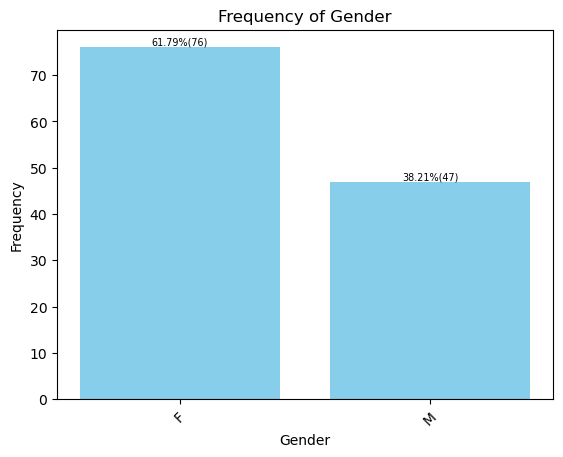

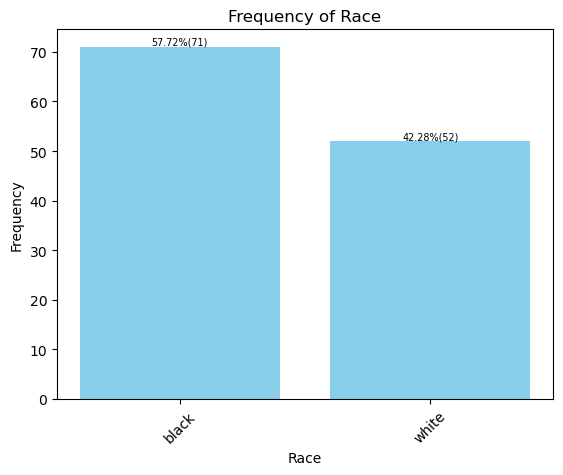

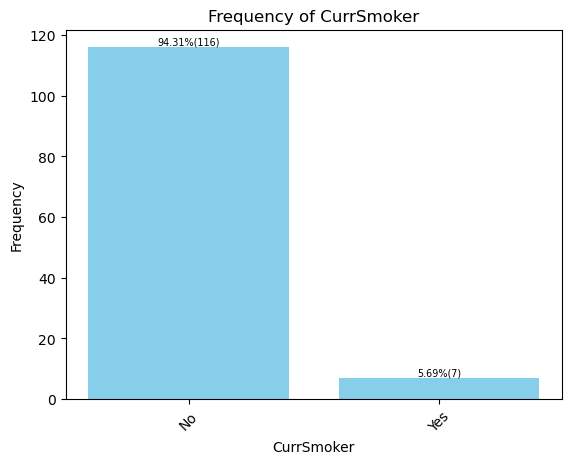

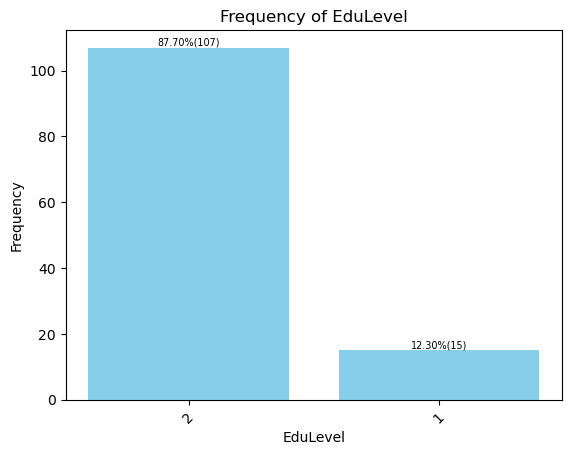

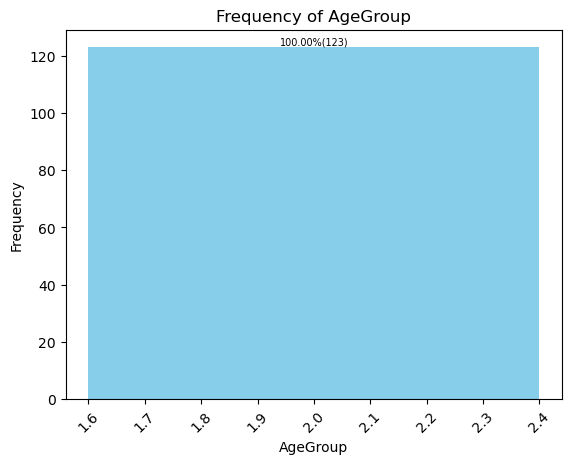

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_hist(df, column_name, show_plot=True, include_legend=True):
    """
    Plots a bar chart of a specified categorical column in the DataFrame with options to include a legend
    showing counts and percentages, and to control the display of the plot.
    
    Parameters:
    - df: Pandas DataFrame containing the data.
    - column_name: String, the name of the column to plot.
    - show_plot: Boolean, if True, display the plot; if False, do not display.
    - include_legend: Boolean, if True, include a legend with counts and percentages.
    """
    if column_name in df.columns:
        # Count the occurrence of each category
        category_counts = df[column_name].value_counts()
        category_percentages = (category_counts / category_counts.sum()) * 100
        
        if show_plot:
            # Plotting the bar chart
            fig, ax = plt.subplots()
            bars = ax.bar(category_counts.index, category_counts.values, color='skyblue')
            ax.set_title(f'Frequency of {column_name}')
            ax.set_xlabel(column_name)
            ax.set_ylabel('Frequency')
            
            if include_legend:
                # Add text annotations for counts and percentages on top of each bar
                for bar, count, percentage in zip(bars, category_counts.values, category_percentages.values):
                    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percentage:.2f}%({count})",
                            ha='center', va='bottom', fontsize='x-small')
            
            plt.xticks(rotation=45)  # Rotate category labels to avoid overlap
            plt.show()
    else:
        print(f"The column '{column_name}' does not exist in the DataFrame.")

# Example usage:
# Assuming you have a DataFrame 'df' with a 'gender' column you want to plot
# df = pd.DataFrame({'gender': ['Male', 'Female', 'Male', 'Female', 'Non-Binary', 'Female', 'Male', 'Non-Binary']})
# plot_categorical_data(df, 'gender', show_plot=True, include_legend=True)
    

plot_hist(df_baseline, "Gender", show_plot=True)           
plot_hist(df_roster, "Race", show_plot=True)
plot_hist(df_baseline, "CurrSmoker", show_plot=True)
plot_hist(df_baseline, "EduLevel", show_plot=True)
plot_hist(df_roster2, 'AgeGroup')
# column_name="Race"
# df = df_roster

# # bin_counts = df[column_name].value_counts()

# category_counts = df[column_name].value_counts()
# category_percentages = (category_counts / category_counts.sum()) * 100
    

# Calculate Numeric Values

In [45]:

def print_stats(df_column):
    """
    Calculate and print the median, minimum, and maximum from a pandas DataFrame column 
    in the format: median [min-max].
    
    Parameters:
    - df_column: A pandas Series (DataFrame column).
    """
    # Ensure the DataFrame column is not empty
    if df_column.empty:
        print("DataFrame column is empty.")
        return
    
    # Calculate statistics
    median = df_column.median()
    column_name = df_column.name
    
    # range
    min_val = df_column.min()
    max_val = df_column.max()
    # print(f"{column_name}: {median} [{min_val}-{max_val}]")
    
    # interquartile range
    Q1 = df_column.quantile(0.25)
    Q3 = df_column.quantile(0.75)
    IQR = Q3 - Q1
    print(f"{column_name}: {median} [{Q1}-{Q3}]")

print_stats(df_roster2.ageAtEnroll)
print_stats(df_baseline.Weight)
print_stats(df_baseline.Height)
print_stats(df_baseline.BMI)
print_stats(df_baseline.DiagT1DAge)
print_stats(df_baseline.HbA1c)
print_stats(df_baseline.BldPrDia)
print_stats(df_baseline.BldPrSys)
print_stats(df_results.Weeks)

ageAtEnroll: 42.0 [31.0-53.0]
Weight: 76.883844 [67.131616-90.38240400000001]
Height: 165.35399999999998 [161.39499999999998-173.55]
BMI: 27.75455906000088 [24.225998609232825-30.758046456531048]
DiagT1DAge: 19.0 [11.5-29.0]
HbA1c: 61.748850000000004 [55.19145000000001-74.86364999999999]
BldPrDia: 72.5 [68.0-80.0]
BldPrSys: 123.0 [114.0-132.75]
Weeks: 9.416666666666668 [7.513392857142858-10.741815476190474]
